<a href="https://colab.research.google.com/github/JimmyLiu8351/liulabtracking/blob/main/eye_test_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow
from PIL import Image
from skimage.draw import line
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
def gradx(img):
    img = img.astype('int')
    rows, cols = img.shape
    # Use hstack to add back in the columns that were dropped as zeros
    return np.hstack( (np.zeros((rows, 1)), (img[:, 2:] - img[:, :-2])/2.0, np.zeros((rows, 1))) )

In [3]:
def grady(img):
    img = img.astype('int')
    rows, cols = img.shape
    # Use vstack to add back the rows that were dropped as zeros
    return np.vstack( (np.zeros((1, cols)), (img[2:, :] - img[:-2, :])/2.0, np.zeros((1, cols))) )

In [4]:
#Performs fast radial symmetry transform
#img: input image, grayscale
#radii: integer value for radius size in pixels (n in the original paper); also used to size gaussian kernel
#alpha: Strictness of symmetry transform (higher=more strict; 2 is good place to start)
#beta: gradient threshold parameter, float in [0,1]
#stdFactor: Standard deviation factor for gaussian kernel
#mode: BRIGHT, DARK, or BOTH
def frst(img, radii, alpha, beta, stdFactor, mode='BOTH'):
    mode = mode.upper()
    assert mode in ['BRIGHT', 'DARK', 'BOTH']
    dark = (mode == 'DARK' or mode == 'BOTH')
    bright = (mode == 'BRIGHT' or mode == 'BOTH')

    workingDims = tuple((e + 2*radii) for e in img.shape)

    #M and O working matrices
    O_n = np.zeros(workingDims, np.int16)
    M_n = np.zeros(workingDims, np.int16)

    #Calculate gradients
    gx = gradx(img)
    gy = grady(img)

    #Find gradient vector magnitude
    gnorms = np.sqrt( np.add( np.multiply(gx, gx) , np.multiply(gy, gy) ) )

    #Use beta to set threshold - speeds up transform significantly
    gthresh = np.amax(gnorms)*beta

    #Find x/y distance to affected pixels
    gpx = np.multiply(np.divide(gx, gnorms, out=np.zeros(gx.shape), where=gnorms!=0), radii).round().astype(int);
    gpy = np.multiply(np.divide(gy, gnorms, out=np.zeros(gy.shape), where=gnorms!=0), radii).round().astype(int);

    #Iterate over all pixels (w/ gradient above threshold)
    for coords, gnorm in np.ndenumerate(gnorms):
        if gnorm > gthresh:
            i, j = coords
            #Positively affected pixel
            if bright:
                ppve = (i+gpy[i,j]+radii, j+gpx[i,j]+radii)
                O_n[ppve] += 1
                M_n[ppve] += gnorm
            #Negatively affected pixel
            if dark:
                pnve = (i-gpy[i,j]+radii, j-gpx[i,j]+radii)
                O_n[pnve] -= 1
                M_n[pnve] -= gnorm

    

    #Abs and normalize O matrix
    O_n = np.abs(O_n)
    O_n = O_n / float(np.amax(O_n))

    #Normalize M matrix
    M_max = float(np.amax(np.abs(M_n)))
    M_n = M_n / M_max

    #Elementwise multiplication
    F_n = np.multiply(np.power(O_n, alpha), M_n)

    #Gaussian blur
    kSize = int( np.ceil( radii / 2 ) )
    kSize = kSize + 1 if kSize % 2 == 0 else kSize

    S = cv2.GaussianBlur(F_n, (kSize, kSize), int( radii * stdFactor ))
    
    return S[radii:-radii,radii:-radii]

In [5]:
def rough_corneal_remove(gray_frame, replace_val):
    # roughly removing corneal reflection
    blur_frame = cv2.blur(gray_frame, (5, 5))
    ret, thresh_frame = cv2.threshold(blur_frame, 100, 255, cv2.THRESH_BINARY)

    for (x, y), value in np.ndenumerate(thresh_frame):
        if value > 0:
            gray_frame[x, y] = replace_val
    
    return cv2.blur(gray_frame, (5, 5))

In [6]:
def estimate(frame, radius_lst):
    # convert frame to grayscale
    if len(frame.shape) != 2:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame

    gray_frame = rough_corneal_remove(gray_frame, np.mean(gray_frame))

    #frst
    frst_sum = np.zeros(gray_frame.shape)
    for i in radius_lst:
        result = frst(gray_frame, i, 2, 0.2, 0, mode='DARK')
        frst_sum = np.add(frst_sum, result)

    # argmin finds the min index as if frst_sum is flattened,
    # so we have to reverse that using unravel_index
    eye_estimate = np.unravel_index(frst_sum.argmin(), frst_sum.shape)[::-1]
    
    return eye_estimate

In [7]:
def starburst(frame, eye):
    FACTORS = [(0, 1), (0, -1), (1, 0), (-1, 0),
                (1, 1), (1, -1), (-1, 1), (-1, -1),
                (1, 2), (-1, 2), (1, -2), (-1, -2),
                (2, 1), (-2, 1), (2, -1), (-2, -1)]
    PUPIL_IRIS_RATIO = 0.8

    # convert frame to grayscale
    if len(frame.shape) != 2:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame

    gray_frame = rough_corneal_remove(gray_frame, gray_frame.min())

    # minimum distance estimate for line_lst
    shape = gray_frame.shape
    dst = min(abs(0 - eye[1]), abs(0 - eye[0]), abs(eye[0] - shape[0]), abs(eye[1] - shape[1]))

    feature_points = []
    distances = []

    for factor in FACTORS:
        edge = (eye[0] + factor[0] * dst, eye[1] + factor[1] * dst)
        line_lst = list(zip(*line(*eye, *edge)))

        previous_vals = []
        for point in line_lst:
            # outside the frame
            if point[0] < 0 or point[0] >= shape[1] or point[1] < 0 or point[1] >= shape[0]:
                break

            val = gray_frame[(point[1], point[0])] # reverse coordinates for inconsistency
            previous_vals.append(val)
            if len(previous_vals) > 7: # minimum radius
                pupil_avg = sum(previous_vals[:-2]) / len(previous_vals[:-2])
                iris_avg = sum(previous_vals[-2:]) / len(previous_vals[-2:])
                if pupil_avg < iris_avg * PUPIL_IRIS_RATIO:
                    feature_points.append(point)
                    distances.append(len(previous_vals))
                    break

    return feature_points, distances



In [26]:
def ellipse(frame, ctr, dist):
    std = np.std(dist)
    mean = np.mean(dist)
    processed_ctr = []
    for idx in range(len(ctr)):
        if mean - std < dist[idx] and dist[idx] < mean + std:
            processed_ctr.append(ctr[idx])

    processed_ctr = np.array(processed_ctr)

    if len(processed_ctr) == 0:
        return None
    else:
        return cv2.fitEllipse(processed_ctr)


In [27]:
# opening the video in videocapture

file_path = "/content/gdrive/MyDrive/mouse_eye_tracking/fixedSFblink.avi"
vidcap = cv2.VideoCapture(file_path)

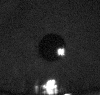

In [32]:
# reading the frame from video

ret, frame = vidcap.read()
#for i in range(200):
#    ret, frame = vidcap.read()
frame = frame[80:175, 100:200]
cv2_imshow(frame)

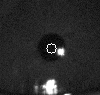

In [31]:
# run the estimate
eye = estimate(frame, [14, 16, 18])
cv2.circle(frame, eye, 5, (255, 255, 255))
cv2_imshow(frame)

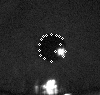

In [33]:
eye = estimate(frame, [10, 12, 14])
ctr, dist = starburst(frame, eye)

for point in ctr:
    cv2.circle(frame, tuple(point), 1, (255, 255, 255))

cv2_imshow(frame)

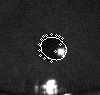

In [34]:
eye = estimate(frame, [10, 12, 14])
ctr, dist = starburst(frame, eye)
std = np.std(dist)
mean = np.mean(dist)
processed_ctr = []
for idx in range(len(ctr)):
    if mean - std < dist[idx] and dist[idx] < mean + std:
        processed_ctr.append(ctr[idx])

processed_ctr = np.array(processed_ctr)

fitted_ellipse = cv2.fitEllipse(processed_ctr)
cv2.ellipse(frame, fitted_ellipse, (255, 255, 255), 1)
cv2_imshow(frame)

In [29]:
progress_bar = tqdm(total=int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
ret, frame = vidcap.read()
frame = frame[80:175, 100:200]
while ret:
    eye = estimate(frame, [10, 12, 14])
    for i in range(5):
        ctr, dist = starburst(frame, eye)
        fitted_ellipse = ellipse(frame, ctr, dist)
        ret, frame = vidcap.read()
        frame = frame[80:175, 100:200]
        progress_bar.update(1)









  0%|          | 0/24002 [00:00<?, ?it/s]







  0%|          | 2/24002 [00:00<20:29, 19.52it/s]







  0%|          | 6/24002 [00:00<18:48, 21.27it/s]







  0%|          | 11/24002 [00:00<17:19, 23.09it/s]







  0%|          | 16/24002 [00:00<16:19, 24.49it/s]







  0%|          | 21/24002 [00:00<15:18, 26.12it/s]







  0%|          | 26/24002 [00:00<14:19, 27.91it/s]







  0%|          | 31/24002 [00:01<13:36, 29.37it/s]







  0%|          | 36/24002 [00:01<13:08, 30.40it/s]







  0%|          | 41/24002 [00:01<12:50, 31.09it/s]







  0%|          | 46/24002 [00:01<12:37, 31.63it/s]







  0%|          | 51/24002 [00:01<12:19, 32.41it/s]







  0%|          | 56/24002 [00:01<12:28, 31.98it/s]







  0%|          | 61/24002 [00:01<12:18, 32.40it/s]







  0%|          | 66/24002 [00:02<12:10, 32.74it/s]







  0%|          | 71/24002 [00:02<12:05, 32.98it/s]







  0%|          | 76/24002 [00:02<12:01, 33.16it/s]







  0%|          | 

KeyboardInterrupt: ignored